# Analyzing Stock Prices with Deep Learning

Analyzing stock prices is a complex challenge that involves uncovering hidden patterns and predicting future trends based on historical data. Deep learning techniques, such as Long Short-Term Memory (LSTM) networks, offer a powerful solution by learning from sequential stock market data to identify trends and relationships over time. Our application uses these models to predict stock movements, helping investors gain insights into market dynamics and improve decision-making. By harnessing the power of deep learning, we can detect patterns that may not be immediately obvious, enabling smarter, data-driven investment strategies.

We will evaluate a particularly volatile stock, Tesla (TSLA). As a highly volatile stock, Tesla makes an excellent example for a deep learning LSTM (Long Short-Term Memory) project due to its dynamic and unpredictable price movements. The company’s stock is influenced by a multitude of factors, such as market sentiment, technological advancements, production targets, regulatory changes, and macroeconomic conditions. This inherent volatility makes Tesla’s stock price a challenging but rewarding target for predictive modeling.

-----------------------------------------------------------------------------------------------------

## Importing Dependencies

We’ll use yfinance to download historical stock data directly from Yahoo Finance. NumPy and Pandas will assist with data manipulation and preparation, while Matplotlib will be used for visualizing the stock price trends. For data preprocessing, we’ll employ MinMaxScaler from Scikit-learn to normalize the data. To build and train our predictive model, we’ll leverage TensorFlow and Keras, specifically using LSTM layers for time series forecasting, along with Dropout layers to reduce overfitting. This combination of tools will allow us to efficiently analyze the stock market and make accurate predictions.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


-----------------------------------------------------------------------------------------------------

## Exploratory Data Analysis

The training dataset spans from January 1, 2018, to January 1, 2025, allowing us to model Tesla's stock price dynamics through a period of rapid growth, increased public attention, and technological advancements.

In [2]:
# Download stock data for Tesla (TSLA) over the past 5 years
ticker = 'TSLA'
data = yf.download(ticker, start='2018-01-01', end='2025-01-01')

# View the data
data.head()
# Check column names



[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000
2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500
2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500
2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000
2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000


### Data Visualization and Inspection

We begin by inspecting the structure and contents of the stock data. First, we display the first few rows of the training dataset to get an overview of the data. This allows us to confirm the presence of important columns such as 'Close', 'Volume', and other relevant fields. Additionally, we check the data types to ensure they are appropriate for further analysis.

Next, we visualize the stock price trends by plotting the closing price for the datasets. This helps us understand the overall trend, seasonality, and volatility in the data:

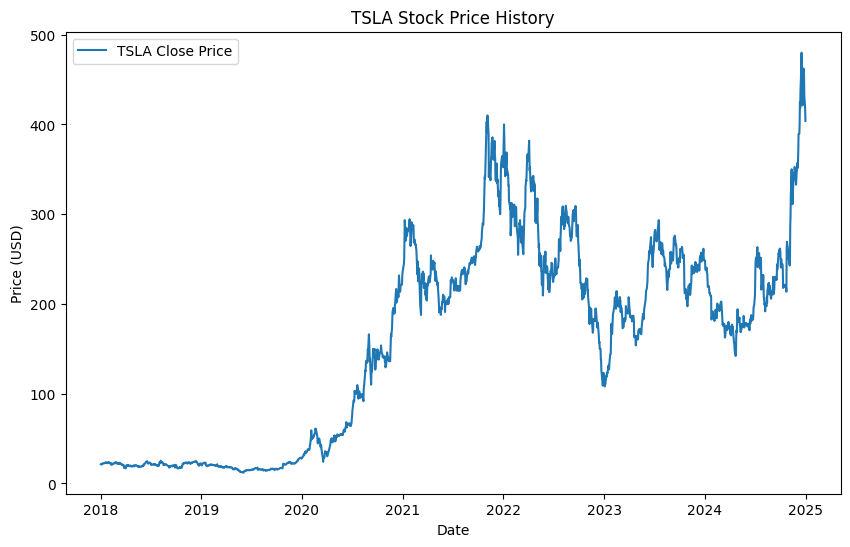

In [3]:
# Plot the 'Close' prices for TSLA
plt.figure(figsize=(10, 6))
plt.plot(data[('Close', 'TSLA')], label=f'{ticker} Close Price')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## Feature Engineering: Volatility, SMA, and RSI Calculation

In this section, we enhance the dataset by calculating additional technical features that can provide deeper insights into Tesla's stock performance. These features include volatility, Simple Moving Average (SMA), and Relative Strength Index (RSI), all of which are commonly used in financial analysis to identify trends and market conditions.

1) Returns: We begin by calculating daily stock returns, which represent the percentage change in the stock's closing price from one day to the next. This helps capture the daily fluctuations in Tesla's stock price.

2) Volatility: We calculate volatility as the rolling 20-day standard deviation of returns. Volatility measures the degree of variation in the stock's returns over time and can be a useful indicator of market uncertainty or risk.

3) Simple Moving Average (SMA): The 20-day SMA smooths out price data over a 20-day window, providing a clearer view of Tesla's price trend and helping identify short-term price movements.

4) Relative Strength Index (RSI): The 14-day RSI helps gauge whether Tesla’s stock is overbought or oversold. A value above 70 typically indicates overbought conditions, while a value below 30 signals oversold conditions.

Finally, we clean the data by dropping any NaN values generated during the rolling window calculations. These additional features will serve as important inputs for the deep learning model, potentially improving its ability to predict future stock price movements.

In [4]:
# Calculate additional features (volatility, SMA, RSI)
# Calculate returns
data['Returns'] = data['Close'].pct_change()

# Calculate volatility as rolling standard deviation of returns
data['Volatility'] = data['Returns'].rolling(window=20).std()

# Calculate the 20-day simple moving average (SMA)
data['SMA'] = data['Close'].rolling(window=20).mean()

# Calculate the 14-day RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values generated by the rolling windows
data = data.dropna()

### Data Preprocessing:

Prepare the data for modeling by selecting relevant features, scaling, and creating sequences of historical data. We choose 'Close', 'Volatility', 'SMA', and 'RSI' as the input features for the model. These features are then normalized using the MinMaxScaler to ensure all values fall within the same range, improving model performance. Next, we construct a dataset of 60-day sequences to predict the next day's closing price. Finally, the data is split into training and testing sets, ready for use in the deep learning model.

In [5]:
# Select the features to use in the model
features = ['Close', 'Volatility', 'SMA', 'RSI']

# Extract the selected features
data_features = data[features].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_features)

# Create a dataset of 60 days' worth of prices as features to predict the next day's price
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])  # Include all features for each time step
        y.append(data[i, 0])  # Predict only the 'Close' price (first column)
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled)

# Reshape X to be 3D (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the data into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

-----------------------------------------------------------------------------------------------------

## Model Building and Training

### Hyperparameter Tuning

In this section, we define a function to build an LSTM model for stock price prediction, with configurable layers, units, and dropout rates. The model is designed to handle time-series data with a 3D input shape (samples, time steps, features). We then set up a random search for hyperparameter tuning, exploring different values for the number of layers, units per layer, dropout rates, batch sizes, and epochs. The model is trained and evaluated multiple times with random combinations of these parameters, aiming to find the best configuration for predicting Tesla's stock prices.

In [6]:
import random

def build_lstm_model(n_layers=2, n_units=50, dropout_rate=0.2):
    model = Sequential()

    # Ensure the input shape is 3D: (samples, time_steps, features)
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, return_sequences=True))  # Return sequences for next layer
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units=n_units, return_sequences=False))  # Last LSTM layer does not return sequences
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

    
# Define the ranges for each hyperparameter
n_layers_options = [1, 2, 3]
n_units_options = [50, 100, 150]
dropout_options = [0.2, 0.3, 0.5]
batch_size_options = [16, 32, 64]
epochs_options = [10, 20]

# Randomly select values from these options
n_trials = 10  # Number of random trials

for _ in range(n_trials):
    n_layers = random.choice(n_layers_options)
    n_units = random.choice(n_units_options)
    dropout = random.choice(dropout_options)
    batch_size = random.choice(batch_size_options)
    epochs = random.choice(epochs_options)

    print(f"Testing with n_layers={n_layers}, n_units={n_units}, dropout={dropout}, batch_size={batch_size}, epochs={epochs}")
    model = build_lstm_model(n_layers, n_units, dropout)  # Custom function to build the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    score = model.evaluate(X_test, y_test)
    print(f"Score: {score}")


Testing with n_layers=2, n_units=150, dropout=0.3, batch_size=64, epochs=10
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


C:\Users\Jacob\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 0.0481
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0043
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 0.0030
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 0.0028
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - loss: 0.0023
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0023
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0022
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0021
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0026
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0019
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 
Score: 0.002783722011372447
Testing with n_layers=3, n_units=100, dropout=0.2, batch_size=64, epochs=20
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0454
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0054
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━

### Final Model Architecture and Training

In this section, we build and train the final LSTM model using the best hyperparameters identified from previous tuning trials. The model consists of 2 LSTM layers, each with 150 units and a dropout rate of 0.2 to prevent overfitting. 

The first LSTM layer returns sequences, while the subsequent layers are designed to process sequential data before passing the final output through a Dense layer. The model is compiled using the Adam optimizer with a mean squared error loss function. Finally, the model is trained for 20 epochs with a batch size of 32, using the training and validation datasets to optimize its performance on predicting Tesla's stock prices.

In [19]:
# Initialize the LSTM model
model = Sequential()

# Add the LSTM layers based on the best hyperparameters
n_layers = 2  # Number of LSTM layers
n_units = 150  # Number of units per LSTM layer
dropout_rate = 0.2  # Dropout rate

# First LSTM layer
model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout_rate))

# Additional LSTM layers
for _ in range(n_layers - 1):
    model.add(LSTM(units=n_units, return_sequences=True))  # Intermediate LSTM layers return sequences
    model.add(Dropout(dropout_rate))

# Final LSTM layer without returning sequences
model.add(LSTM(units=n_units, return_sequences=False))
model.add(Dropout(dropout_rate))

# Add the Dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with the best number of epochs and batch size
batch_size = 32  # Best batch size found
epochs = 20  # Best number of epochs

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/20


C:\Users\Jacob\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0321 - val_loss: 0.0054
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0

### Visualization

In this section, we visualize the training and validation loss over epochs to assess the model's learning progress. By plotting both the Training Loss and Validation Loss, we can evaluate whether the model is overfitting or underfitting. A well-performing model should show decreasing training loss and validation loss over time, indicating that it is learning effectively from the data while generalizing well to unseen examples. The plot helps us track the model's performance and make adjustments if necessary.

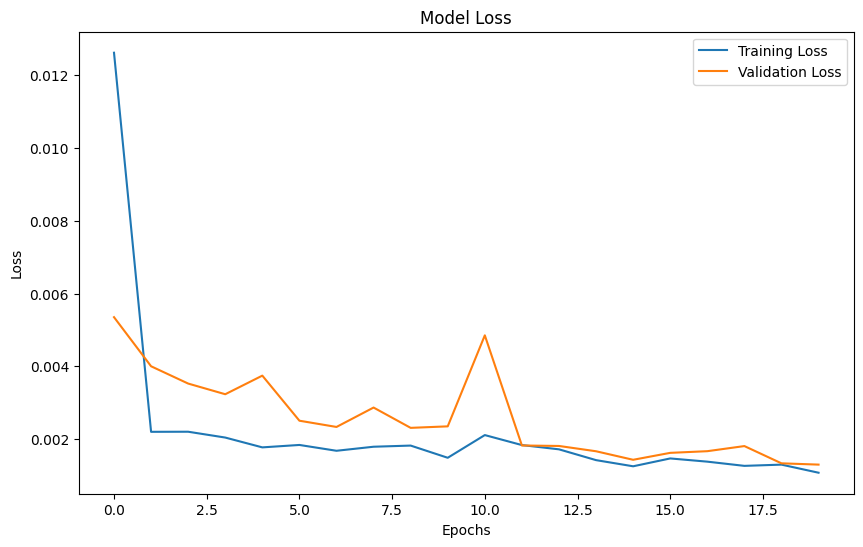

In [20]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predicted vs Actual Stock Prices

In this section, we make predictions on the test set using the trained model and compare the results with the actual stock prices. The predicted prices are first transformed back to their original scale using the inverse scaling method. We then plot both the actual stock prices and predicted stock prices to visually assess the model's performance. A good model will show a close alignment between the predicted and actual prices, indicating its ability to accurately forecast Tesla’s stock movements. This comparison helps us evaluate the model's predictive accuracy and overall effectiveness.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step 


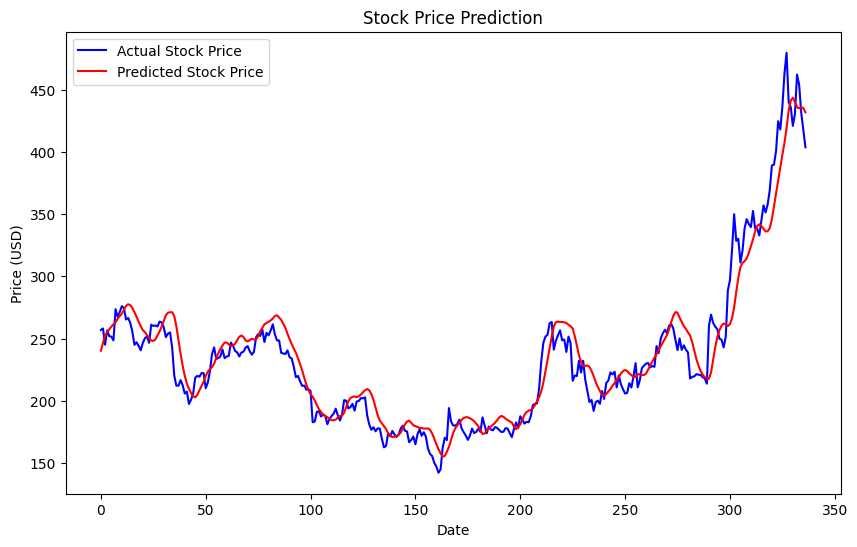

In [21]:
# Predicting stock prices on the test set
predicted_prices = model.predict(X_test)

# Invert scaling to get actual stock prices (only for the Close price)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]

# Plot the predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Model Evaluation

We evaluate the performance of the model by calculating two key metrics: Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). These metrics provide insights into the accuracy of the model’s predictions:

1) RMSE measures the average magnitude of the errors between predicted and actual values, with higher values indicating greater prediction errors.
2) MAE calculates the average absolute differences between predicted and actual values, giving a more straightforward interpretation of the prediction error.
   
By computing these metrics, we can assess how well the model is performing and whether adjustments are needed for further improvement.

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Calculate RMSE and MAE
rmse = math.sqrt(mean_squared_error(y_test_actual, predicted_prices))
mae = mean_absolute_error(y_test_actual, predicted_prices)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Root Mean Squared Error (RMSE): 16.878168084793504
Mean Absolute Error (MAE): 12.645612532047942


-----------------------------------------------------------------------------------------------------

## Final Conclusion

This project demonstrates the potential of deep learning, specifically Long Short-Term Memory (LSTM) networks, in predicting stock prices for a highly volatile stock like Tesla (TSLA). By leveraging historical stock data, technical indicators, and LSTM models, we successfully built a predictive system to analyze Tesla’s stock movements. Despite the inherent challenges of volatility and unpredictability in the stock market, LSTM networks provide a robust tool for identifying patterns in time-series data.

Through a thorough exploration of feature engineering, model building, hyperparameter tuning, and model evaluation, we achieved reasonable performance with a Root Mean Squared Error (RMSE) of 16.88 and a Mean Absolute Error (MAE) of 12.65. These results reflect the model's ability to make accurate predictions, though there is always room for further optimization and improvement, particularly in a dynamic and ever-changing market like Tesla’s.

By understanding and applying deep learning techniques, investors and analysts can gain valuable insights into stock price trends, making more informed decisions. This project highlights the importance of machine learning in financial analysis and opens doors for further advancements in predictive modeling for the stock market.

https://github.com/JacobMullen/DeepLearningFinalMullen/blob/main/DeepLearningFinalMullen.ipynb